# Running NVIDIA Nemotron Models on Fireworks AI

This notebook demonstrates how to deploy and benchmark NVIDIA's Nemotron Nano models on Fireworks AI, comparing them against other popular small language models (8-14B parameter range).

## Table of Contents
- Overview
- Step 1: Setup and Installation
- Step 2: Creating Deployments on Fireworks
- Step 3: GPQA Benchmarking
- Step 4: Qualitative Examples
- Conclusions


## Overview

**Models We'll Benchmark:**
- NVIDIA Nemotron Nano 9B v2
- NVIDIA Nemotron Nano 12B v2
- Qwen3 8B
- Qwen3 14B
- Llama 3.1 8B Instruct

**What We'll Measure:**
Model quality through a quantitative benchmark and qualitative examples.

**Prerequisites:**
- Fireworks AI account ([sign up here](https://fireworks.ai))
- `firectl` CLI tool installed
- Create a `.env` file with your `FIREWORKS_API_KEY`

## Step 1: Setup and Installation

First, create a `.env` file in this directory with your Fireworks API key:

```bash
# Create .env file with your actual API key
cat > .env << EOF
FIREWORKS_API_KEY=your-fireworks-api-key-here
HF_TOKEN=your-huggingface-token-here
EOF
```

Get your API keys:
- **Fireworks API Key**: [https://app.fireworks.ai/settings/users/api-keys](https://app.fireworks.ai/settings/users/api-keys)
- **Hugging Face Token** (for GPQA dataset): [https://huggingface.co/settings/tokens](https://huggingface.co/settings/tokens)

**Important**: The `.env` file is in `.gitignore` to protect your API keys from being committed.

Now install the necessary dependencies:

In [7]:
# Install required packages using uv
!uv pip install -q fireworks-ai pandas matplotlib seaborn requests datasets huggingface-hub python-dotenv


In [8]:
import os
import json
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Verify API key is loaded
FIREWORKS_API_KEY = os.getenv('FIREWORKS_API_KEY')
if not FIREWORKS_API_KEY:
    print("⚠️  WARNING: FIREWORKS_API_KEY not found!")
    print("Please create a .env file in the cookbook root directory:")
    print("FIREWORKS_API_KEY=your-api-key-here")
else:
    print("✓ FIREWORKS_API_KEY loaded from .env file")


✓ FIREWORKS_API_KEY loaded from .env file


## Step 2: Create Deployments

We'll create on-demand deployments for each model using Fireworks' `firectl` CLI. Each deployment will use a single H100 GPU for consistent comparisons.

**Note**: Make sure you have `firectl` installed and authenticated:
```bash
brew tap fw-ai/firectl
brew install firectl
firectl signin
```


In [43]:
# Define model configurations
model_configs = {
    "nemotron-nano-9b": {
        "model_path": "accounts/fireworks/models/nvidia-nemotron-nano-9b-v2",
        "display_name": "NVIDIA Nemotron Nano 9B v2"
    },
    "nemotron-nano-12b": {
        "model_path": "accounts/fireworks/models/nvidia-nemotron-nano-12b-v2", 
        "display_name": "NVIDIA Nemotron Nano 12B v2"
    },
    "qwen3-8b": {
        "model_path": "accounts/fireworks/models/qwen3-8b",
        "display_name": "Qwen3 8B"
    },
    "qwen3-14b": {
        "model_path": "accounts/fireworks/models/qwen3-14b",
        "display_name": "Qwen3 14B"
    },
    "llama-3.1-8b": {
        "model_path": "accounts/fireworks/models/llama-v3p1-8b-instruct",
        "display_name": "Llama 3.1 8B Instruct"
    }
}

print("Model configurations loaded:")
for key, config in model_configs.items():
    print(f"  • {config['display_name']}: {config['model_path']}")


Model configurations loaded:
  • NVIDIA Nemotron Nano 9B v2: accounts/fireworks/models/nvidia-nemotron-nano-9b-v2
  • NVIDIA Nemotron Nano 12B v2: accounts/fireworks/models/nvidia-nemotron-nano-12b-v2
  • Qwen3 8B: accounts/fireworks/models/qwen3-8b
  • Qwen3 14B: accounts/fireworks/models/qwen3-14b
  • Llama 3.1 8B Instruct: accounts/fireworks/models/llama-v3p1-8b-instruct


### Create Deployments with Firectl

The following commands create on-demand deployments for each model. Each deployment uses a single H100 GPU.


In [ ]:
!firectl create deployment accounts/fireworks/models/nvidia-nemotron-nano-9b-v2 \
    --display-name "Nemotron Nano 9B Benchmark" \
    --accelerator-type NVIDIA_H100_80GB \
    --accelerator-count 1 \
    --region US_TEXAS_2 \
    --min-replica-count 1 \
    --max-replica-count 1


In [ ]:
!firectl create deployment accounts/fireworks/models/nvidia-nemotron-nano-12b-v2 \
    --display-name "Nemotron Nano 12B Benchmark" \
    --accelerator-type NVIDIA_H100_80GB \
    --accelerator-count 1 \
    --region US_TEXAS_2 \
    --min-replica-count 1 \
    --max-replica-count 1


In [ ]:
!firectl create deployment accounts/fireworks/models/qwen3-8b \
    --display-name "Qwen3 8B Benchmark" \
    --accelerator-type NVIDIA_H100_80GB \
    --accelerator-count 1 \
    --region US_TEXAS_2 \
    --min-replica-count 1 \
    --max-replica-count 1


In [ ]:
!firectl create deployment accounts/fireworks/models/qwen3-14b \
    --display-name "Qwen3 14B Benchmark" \
    --accelerator-type NVIDIA_H100_80GB \
    --accelerator-count 1 \
    --region US_TEXAS_2 \
    --min-replica-count 1 \
    --max-replica-count 1


In [ ]:
!firectl create deployment accounts/fireworks/models/llama-v3p1-8b-instruct \
    --display-name "Llama 3.1 8B Benchmark" \
    --accelerator-type NVIDIA_H100_80GB \
    --accelerator-count 1 \
    --region US_TEXAS_2 \
    --min-replica-count 1 \
    --max-replica-count 1


### Verify Deployments

Check that all deployments are created and running:


In [ ]:
# List all deployments
!firectl list deployments

In [10]:
# Store deployment IDs manually after creating them
# After running the firectl commands above, fill in your deployment IDs here
deployments = {
    "nemotron-nano-9b": "accounts/YOUR_ACCOUNT/deployments/DEPLOYMENT_ID_1",
    "nemotron-nano-12b": "accounts/YOUR_ACCOUNT/deployments/DEPLOYMENT_ID_2",
    "qwen2.5-8b": "accounts/YOUR_ACCOUNT/deployments/DEPLOYMENT_ID_3",
    "qwen2.5-14b": "accounts/YOUR_ACCOUNT/deployments/DEPLOYMENT_ID_4",
    "llama-3.1-8b": "accounts/YOUR_ACCOUNT/deployments/DEPLOYMENT_ID_5"
}

print("Deployment configuration ready")


Deployment configuration ready


## Step 3: Accuracy Benchmarking with GPQA Diamond

For accuracy evaluation, we'll use the **GPQA Diamond** dataset - a challenging benchmark of graduate-level questions in biology, physics, and chemistry.

### About GPQA Diamond

[GPQA (Graduate-Level Google-Proof Q&A)](https://arxiv.org/abs/2311.12022) is a rigorous multiple-choice dataset where:
- **Expert accuracy**: PhD-level experts in their domain achieve 65-74% accuracy
- **Non-expert accuracy**: Highly skilled validators outside the domain only reach 34% despite 30+ minutes with Google
- **198 questions** in GPQA Diamond (the highest quality subset)
- **Domains**: Biology, Physics, and Chemistry

This makes it an excellent benchmark for testing reasoning capabilities of our models.

**Note**: Per dataset guidelines, we won't display full question text in plain text to prevent training data leakage.

### Download GPQA Diamond Dataset

First, create the data directory:


In [35]:
!mkdir -p benchmark/llm_bench/data


In [36]:
print("✓ Created data directory: benchmark/llm_bench/data")
print("\n📝 Note: You'll need to accept the dataset terms on Hugging Face to download GPQA.")


✓ Created data directory: benchmark/llm_bench/data

📝 Note: You'll need to accept the dataset terms on Hugging Face to download GPQA.


### Load GPQA Dataset from Hugging Face

**Important**: Before running this cell, you need to:
1. Visit [https://huggingface.co/datasets/Idavidrein/gpqa](https://huggingface.co/datasets/Idavidrein/gpqa)
2. Accept the dataset terms (agree NOT to reveal examples in plain text online)
3. Authenticate with Hugging Face: `huggingface-cli login` or set `HF_TOKEN` environment variable


In [39]:
from datasets import load_dataset
from dotenv import load_dotenv
from openai import OpenAI

client = OpenAI(
    base_url="https://api.fireworks.ai/inference/v1",
    api_key=os.getenv('FIREWORKS_API_KEY'),
)

load_dotenv()

HF_TOKEN = os.getenv('HF_TOKEN')

# Load GPQA Diamond dataset
try:
    dataset = load_dataset("Idavidrein/gpqa", "gpqa_diamond")
    gpqa_questions = dataset['train']  # GPQA Diamond only has a train split
    
    print(f"✓ Successfully loaded GPQA Diamond dataset")
    print(f"  Total questions: {len(gpqa_questions)}")
    print(f"\n  Subdomain distribution:")
    
    # Show domain distribution
    from collections import Counter
    domains = Counter([q['Subdomain'] for q in gpqa_questions])
    for domain, count in domains.items():
        print(f"    • {domain}: {count} questions")
    
    # Save to local directory for reference
    gpqa_df = pd.DataFrame(gpqa_questions)
    gpqa_df.to_csv('benchmark/llm_bench/data/gpqa_diamond.csv', index=False)
    print(f"\n  Saved to: benchmark/llm_bench/data/gpqa_diamond.csv")
    
except Exception as e:
    print(f"✗ Error loading GPQA dataset: {e}")
    print("\nPlease ensure you have:")
    print("  1. Accepted the dataset terms at https://huggingface.co/datasets/Idavidrein/gpqa")
    print("  2. Authenticated with: huggingface-cli login")
    print("     or set HF_TOKEN environment variable")


✓ Successfully loaded GPQA Diamond dataset
  Total questions: 198

  Subdomain distribution:
    • Physics (general): 19 questions
    • Organic Chemistry: 72 questions
    • Quantum Mechanics: 25 questions
    • Electromagnetism and Photonics: 6 questions
    • High-energy particle physics: 14 questions
    • Genetics: 4 questions
    • Astrophysics: 13 questions
    • Molecular Biology: 15 questions
    • Chemistry (general): 20 questions
    • Relativistic Mechanics: 7 questions
    • Inorganic Chemistry: 1 questions
    • Optics and Acoustics: 1 questions
    • Condensed Matter Physics: 1 questions

  Saved to: benchmark/llm_bench/data/gpqa_diamond.csv


In [ ]:
# Set model configs to include deployment_path
model_configs = {
    'nemotron_9b': {
        'display_name': 'Nemotron 9B',
        'model_path': 'accounts/fireworks/models/nvidia-nemotron-nano-9b-v2',
        'deployment_path': 'accounts/YOUR_ACCOUNT/deployments/YOUR_DEPLOYMENT_ID',
    },
    'nemotron_12b': {
        'display_name': 'Nemotron 12B', 
        'model_path': 'accounts/fireworks/models/nvidia-nemotron-nano-12b-v2',
        'deployment_path': 'accounts/YOUR_ACCOUNT/deployments/YOUR_DEPLOYMENT_ID',
    },
    'qwen3_8b': {
        'display_name': 'Qwen3 8B',
        'model_path': 'accounts/fireworks/models/qwen3-8b',
        'deployment_path': 'accounts/YOUR_ACCOUNT/deployments/YOUR_DEPLOYMENT_ID',
    },
    'qwen3_14b': {
        'display_name': 'Qwen3 14B',
        'model_path': 'accounts/fireworks/models/qwen3-14b',
        'deployment_path': 'accounts/YOUR_ACCOUNT/deployments/YOUR_DEPLOYMENT_ID',
    },
    'llama_3p1_8b': {
        'display_name': 'Llama 3.1 8B',
        'model_path': 'accounts/fireworks/models/llama-v3p1-8b-instruct',
        'deployment_path': 'accounts/YOUR_ACCOUNT/deployments/YOUR_DEPLOYMENT_ID',
    },
}

# Construct full model identifiers (model_path#deployment_path)
for key, config in model_configs.items():
    config['full_model_id'] = f"{config['model_path']}#{config['deployment_path']}"

print("✓ Model configurations loaded:")
for key, config in model_configs.items():
    print(f"  • {config['display_name']}: {config['full_model_id']}")

In [ ]:
import os
import json
import re
import random
from datetime import datetime
from pathlib import Path

def parse_answer(response_text):
    """
    Parse the model's response to extract the answer letter.
    First tries strict last-line parsing, then falls back to LaTeX-aware parsing.
    Returns None if not found in correct format.
    """
    lines = response_text.strip().split('\n')
    
    # FIRST: Try strict last line parsing (current method)
    if lines:
        last_line = lines[-1].strip()
        answer_match = re.search(r'ANSWER:\s*([A-D])', last_line, re.IGNORECASE)
        if answer_match:
            return answer_match.group(1).upper()
    
    # FALLBACK: Check last 3 lines with LaTeX formatting removal
    last_lines = lines[-3:] if len(lines) >= 3 else lines
    for line in reversed(last_lines):
        line_clean = line.strip()
        
        # Remove LaTeX formatting: $$, $, \text{...}
        line_clean = line_clean.replace('$$', '').replace('$', '')
        line_clean = re.sub(r'\\text\{([^}]*)\}', r'\1', line_clean)
        line_clean = line_clean.strip()
        
        # Look for "ANSWER: X" pattern (case insensitive)
        answer_match = re.search(r'ANSWER:\s*([A-D])', line_clean, re.IGNORECASE)
        if answer_match:
            return answer_match.group(1).upper()
    
    # If not found in either method, return None
    return None

def evaluate_model_on_gpqa(model_full_id, model_name, questions, max_tokens=128000, temperature=0.1, sample_size=None, random_seed=42):
    """
    Evaluate a model on GPQA questions using standard benchmark prompt format.
    
    Args:
        model_full_id: Full Fireworks model identifier (model_path#deployment_path)
        model_name: Clean model name for log file (e.g., 'nemotron_9b')
        questions: GPQA dataset questions
        max_tokens: Maximum tokens for response
        temperature: Sampling temperature (low for reasoning tasks)
        sample_size: Optional - evaluate on subset of questions
        random_seed: Seed for randomizing answer positions
    
    Returns:
        Dictionary with results and accuracy metrics
    """
    # Set random seed for reproducibility
    random.seed(random_seed)
    
    # Create results/gpqa directory if it doesn't exist
    log_dir = Path("benchmark/llm_bench/results/gpqa")
    log_dir.mkdir(parents=True, exist_ok=True)
    
    # Generate log filename with timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    log_file = log_dir / f"gpqa_{model_name}_{timestamp}.jsonl"
    
    print(f"  Logging to: {log_file}")
    
    # Sample questions if specified
    if sample_size and sample_size < len(questions):
        indices = random.sample(range(len(questions)), sample_size)
        questions_to_eval = [questions[i] for i in indices]
        print(f"  Evaluating on {sample_size} randomly sampled questions")
    else:
        questions_to_eval = questions
        print(f"  Evaluating on all {len(questions)} questions")
    
    results = []
    correct = 0
    parsing_failures = 0
    
    for i, q in enumerate(questions_to_eval):
        # Create list of all answers with labels
        all_answers = [
            ("Correct", q['Correct Answer']),
            ("Incorrect1", q['Incorrect Answer 1']),
            ("Incorrect2", q['Incorrect Answer 2']),
            ("Incorrect3", q['Incorrect Answer 3'])
        ]
        
        # Shuffle the answers
        random.shuffle(all_answers)
        
        # Map shuffled answers to A, B, C, D
        answer_mapping = {
            'A': all_answers[0],
            'B': all_answers[1],
            'C': all_answers[2],
            'D': all_answers[3]
        }
        
        # Find which letter corresponds to the correct answer
        correct_letter = None
        for letter, (label, text) in answer_mapping.items():
            if label == "Correct":
                correct_letter = letter
                break
        
        # Format question with GPQA standard prompt format
        instruction = """Answer the following multiple choice question. The last line of your response should be of the following format: 'ANSWER: $LETTER' (without quotes) where LETTER is one of A,B,C,D. Think step by step before answering.

"""
        
        question_text = instruction
        question_text += f"{q['Question']}\n\n"
        question_text += f"A) {answer_mapping['A'][1]}\n"
        question_text += f"B) {answer_mapping['B'][1]}\n"
        question_text += f"C) {answer_mapping['C'][1]}\n"
        question_text += f"D) {answer_mapping['D'][1]}"
        
        # Build the messages array that will be sent to the model
        messages = [{"role": "user", "content": question_text}]
        
        try:
            response = client.chat.completions.create(
                model=model_full_id,
                messages=messages,
                max_tokens=max_tokens,
                temperature=temperature
            )
            
            full_response = response.choices[0].message.content.strip()
            
            # Check if response was likely cut off (doesn't end with ANSWER: pattern)
            finish_reason = response.choices[0].finish_reason
            response_cutoff = finish_reason == "length"
            
            # Parse the answer from the response (strict parsing)
            parsed_answer = parse_answer(full_response)
            
            # Track if parsing failed
            if parsed_answer is None:
                parsing_failures += 1
                if response_cutoff:
                    print(f"  Warning: Question {i+1} - Response cut off at max_tokens limit")
                else:
                    print(f"  Warning: Question {i+1} - Failed to parse answer (model didn't follow format)")
            
            # Check if answer is correct
            is_correct = parsed_answer == correct_letter if parsed_answer else False
            if is_correct:
                correct += 1
            
            result_entry = {
                "question_index": i,
                "subdomain": q['Subdomain'],
                "question": q['Question'],
                "choices": {
                    "A": answer_mapping['A'][1],
                    "B": answer_mapping['B'][1],
                    "C": answer_mapping['C'][1],
                    "D": answer_mapping['D'][1]
                },
                "correct_answer": correct_letter,
                "answer_mapping": {k: v[0] for k, v in answer_mapping.items()},
                "model_input": messages,
                "model_full_response": full_response,
                "model_parsed_answer": parsed_answer,
                "parsing_failed": parsed_answer is None,
                "response_cutoff": response_cutoff,
                "finish_reason": finish_reason,
                "is_correct": is_correct,
                "temperature": temperature,
                "max_tokens": None,
                "random_seed": random_seed,
                "timestamp": datetime.now().isoformat()
            }
            
            results.append({
                "subdomain": q['Subdomain'],
                "answer": parsed_answer,
                "is_correct": is_correct
            })
            
            # Log to file immediately
            with open(log_file, 'a') as f:
                f.write(json.dumps(result_entry) + '\n')
            
            # Progress update every 10 questions
            if (i + 1) % 10 == 0:
                current_acc = (correct / (i + 1)) * 100
                print(f"  Progress: {i+1}/{len(questions_to_eval)} | Current accuracy: {current_acc:.1f}% | Parse failures: {parsing_failures}")
                
        except Exception as e:
            print(f"  Error on question {i+1}: {e}")
            error_entry = {
                "question_index": i,
                "subdomain": q['Subdomain'],
                "question": q['Question'],
                "model_input": messages,
                "error": str(e),
                "is_correct": False,
                "timestamp": datetime.now().isoformat()
            }
            
            results.append({
                "subdomain": q['Subdomain'],
                "answer": None,
                "is_correct": False
            })
            
            with open(log_file, 'a') as f:
                f.write(json.dumps(error_entry) + '\n')
    
    accuracy = (correct / len(results)) * 100 if results else 0
    parsing_failure_rate = (parsing_failures / len(results)) * 100 if results else 0
    
    # Write summary at the end of log file
    summary = {
        "summary": True,
        "model_id": model_full_id,
        "model_name": model_name,
        "total_questions": len(results),
        "correct": correct,
        "accuracy": accuracy,
        "parsing_failures": parsing_failures,
        "parsing_failure_rate": parsing_failure_rate,
        "sample_size": sample_size,
        "temperature": temperature,
        "max_tokens": max_tokens,
        "random_seed": random_seed,
        "prompt_format": "GPQA standard (strict last-line parsing, randomized positions)",
        "timestamp": datetime.now().isoformat()
    }
    
    with open(log_file, 'a') as f:
        f.write(json.dumps(summary) + '\n')
    
    print(f"  ✓ Results logged to: {log_file}")
    print(f"  ✓ Parsing failures: {parsing_failures}/{len(results)} ({parsing_failure_rate:.1f}%)")
    
    return {
        'results': results,
        'accuracy': accuracy,
        'correct': correct,
        'total': len(results),
        'parsing_failures': parsing_failures,
        'log_file': str(log_file)
    }

print("✓ GPQA evaluation function ready (with strict answer parsing and high token limit)")

✓ GPQA evaluation function ready (with strict answer parsing and high token limit)


### Run GPQA Evaluation on All Models

**Note**: This will make API calls for each model. Options:
- Set `SAMPLE_SIZE = 50` for faster testing (evaluates on 50 random questions)
- Set `SAMPLE_SIZE = None` for full evaluation (all 198 questions, takes longer)


In [ ]:
# Evaluate Nemotron 9B
# ============================================================================
SAMPLE_SIZE = 50

model_key = 'nemotron_9b'
model_config = model_configs[model_key]

print(f"\n{'='*80}")
print(f"Evaluating: {model_config['display_name']}")
print(f"Model ID: {model_config['full_model_id']}")
print(f"{'='*80}")

try:
    result = evaluate_model_on_gpqa(
        model_config['full_model_id'],
        model_key,
        gpqa_questions,
        sample_size=SAMPLE_SIZE
    )
    
    print(f"\n✓ {model_config['display_name']} Results:")
    print(f"  Accuracy: {result['accuracy']:.2f}%")
    print(f"  Correct: {result['correct']}/{result['total']}")
    print(f"  Parsing failures: {result['parsing_failures']}")
    print(f"  Log file: {result['log_file']}")
    
except Exception as e:
    print(f"\n✗ Error evaluating {model_config['display_name']}: {e}")

In [ ]:
# Evaluate Nemotron 12B
# ============================================================================
SAMPLE_SIZE = 50

model_key = 'nemotron_12b'
model_config = model_configs[model_key]

print(f"\n{'='*80}")
print(f"Evaluating: {model_config['display_name']}")
print(f"Model ID: {model_config['full_model_id']}")
print(f"{'='*80}")

try:
    result = evaluate_model_on_gpqa(
        model_config['full_model_id'],
        model_key,
        gpqa_questions,
        sample_size=SAMPLE_SIZE
    )
    
    print(f"\n✓ {model_config['display_name']} Results:")
    print(f"  Accuracy: {result['accuracy']:.2f}%")
    print(f"  Correct: {result['correct']}/{result['total']}")
    print(f"  Parsing failures: {result['parsing_failures']}")
    print(f"  Log file: {result['log_file']}")
    
except Exception as e:
    print(f"\n✗ Error evaluating {model_config['display_name']}: {e}")

In [ ]:
# Evaluate Qwen3 8B
# ============================================================================
SAMPLE_SIZE = 50

model_key = 'qwen3_8b'
model_config = model_configs[model_key]

print(f"\n{'='*80}")
print(f"Evaluating: {model_config['display_name']}")
print(f"Model ID: {model_config['full_model_id']}")
print(f"{'='*80}")

try:
    result = evaluate_model_on_gpqa(
        model_config['full_model_id'],
        model_key,
        gpqa_questions,
        sample_size=SAMPLE_SIZE
    )
    
    print(f"\n✓ {model_config['display_name']} Results:")
    print(f"  Accuracy: {result['accuracy']:.2f}%")
    print(f"  Correct: {result['correct']}/{result['total']}")
    print(f"  Parsing failures: {result['parsing_failures']}")
    print(f"  Log file: {result['log_file']}")
    
except Exception as e:
    print(f"\n✗ Error evaluating {model_config['display_name']}: {e}")

In [ ]:
# Evaluate Qwen3 14B
# ============================================================================
SAMPLE_SIZE = 50

model_key = 'qwen3_14b'
model_config = model_configs[model_key]

print(f"\n{'='*80}")
print(f"Evaluating: {model_config['display_name']}")
print(f"Model ID: {model_config['full_model_id']}")
print(f"{'='*80}")

try:
    result = evaluate_model_on_gpqa(
        model_config['full_model_id'],
        model_key,
        gpqa_questions,
        sample_size=SAMPLE_SIZE
    )
    
    print(f"\n✓ {model_config['display_name']} Results:")
    print(f"  Accuracy: {result['accuracy']:.2f}%")
    print(f"  Correct: {result['correct']}/{result['total']}")
    print(f"  Parsing failures: {result['parsing_failures']}")
    print(f"  Log file: {result['log_file']}")
    
except Exception as e:
    print(f"\n✗ Error evaluating {model_config['display_name']}: {e}")

In [ ]:
# Evaluate Llama 3.1 8B
# ============================================================================
SAMPLE_SIZE = 50

model_key = 'llama_3p1_8b'
model_config = model_configs[model_key]

print(f"\n{'='*80}")
print(f"Evaluating: {model_config['display_name']}")
print(f"Model ID: {model_config['full_model_id']}")
print(f"{'='*80}")

try:
    result = evaluate_model_on_gpqa(
        model_config['full_model_id'],
        model_key,
        gpqa_questions,
        sample_size=SAMPLE_SIZE
    )
    
    print(f"\n✓ {model_config['display_name']} Results:")
    print(f"  Accuracy: {result['accuracy']:.2f}%")
    print(f"  Correct: {result['correct']}/{result['total']}")
    print(f"  Parsing failures: {result['parsing_failures']}")
    print(f"  Log file: {result['log_file']}")
    
except Exception as e:
    print(f"\n✗ Error evaluating {model_config['display_name']}: {e}")

### Visualize GPQA Results


Analyzing question distribution from: gpqa_llama_3p1_8b_20251017_013752.jsonl



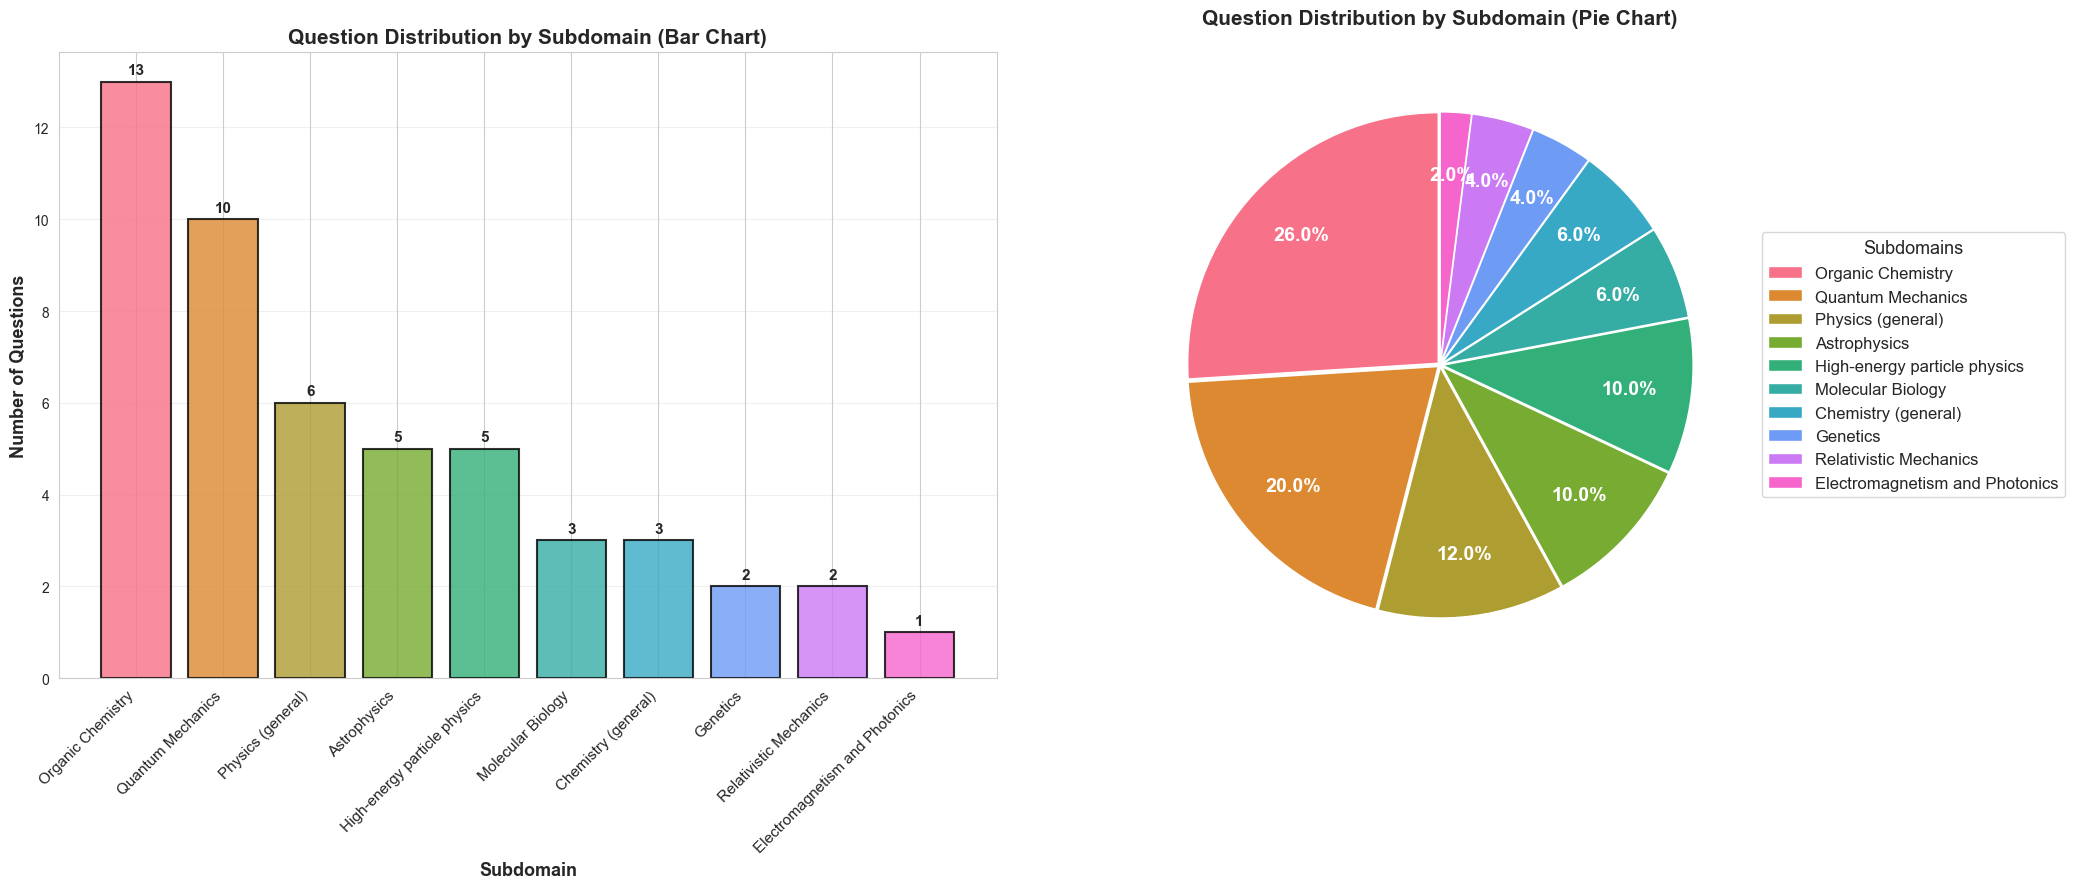


QUESTION DISTRIBUTION BREAKDOWN
Subdomain                           Count      Percentage     
--------------------------------------------------------------------------------
Organic Chemistry                   13           26.0%
Quantum Mechanics                   10           20.0%
Physics (general)                   6            12.0%
Astrophysics                        5            10.0%
High-energy particle physics        5            10.0%
Molecular Biology                   3             6.0%
Chemistry (general)                 3             6.0%
Genetics                            2             4.0%
Relativistic Mechanics              2             4.0%
Electromagnetism and Photonics      1             2.0%
--------------------------------------------------------------------------------
TOTAL                               50         100.0%

✓ Analyzed 50 questions across 10 subdomains


In [110]:
# Visualize GPQA Question Distribution by Subdomain
# ============================================================================
# Shows the distribution of sampled questions across scientific subdomains
# ============================================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import os
from collections import Counter

# Set style
sns.set_style("whitegrid")

# Get the most recent GPQA log file (or specify a specific one)
gpqa_log_dir = "benchmark/llm_bench/results/gpqa"
log_files = sorted(glob.glob(f"{gpqa_log_dir}/gpqa_*.jsonl"), key=os.path.getmtime, reverse=True)

if not log_files:
    print("❌ No GPQA results found.")
else:
    # Use the most recent log file
    log_file = log_files[0]
    print(f"Analyzing question distribution from: {os.path.basename(log_file)}\n")
    
    # Read all questions (exclude summary line)
    subdomains = []
    with open(log_file, 'r') as f:
        for line in f:
            try:
                entry = json.loads(line)
                if not entry.get('summary') and 'subdomain' in entry:
                    subdomains.append(entry['subdomain'])
            except:
                pass
    
    if not subdomains:
        print("❌ No question data found in log file.")
    else:
        # Count subdomain occurrences
        subdomain_counts = Counter(subdomains)
        
        # Convert to DataFrame for easy plotting
        df = pd.DataFrame(list(subdomain_counts.items()), columns=['Subdomain', 'Count'])
        df = df.sort_values('Count', ascending=False)
        
        # Create visualizations with larger spacing
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 9))
        
        # Bar chart
        bars = ax1.bar(range(len(df)), df['Count'], 
                       color=sns.color_palette("husl", len(df)),
                       alpha=0.8, edgecolor='black', linewidth=1.5)
        
        # Add value labels on bars
        for i, (bar, count) in enumerate(zip(bars, df['Count'])):
            ax1.text(i, count + 0.1, str(count),
                    ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        ax1.set_xticks(range(len(df)))
        ax1.set_xticklabels(df['Subdomain'], rotation=45, ha='right', fontsize=11)
        ax1.set_xlabel('Subdomain', fontsize=13, fontweight='bold')
        ax1.set_ylabel('Number of Questions', fontsize=13, fontweight='bold')
        ax1.set_title('Question Distribution by Subdomain (Bar Chart)', fontsize=15, fontweight='bold')
        ax1.grid(True, alpha=0.3, axis='y')
        
        # Pie chart with minimal gaps and bigger text
        colors = sns.color_palette("husl", len(df))
        
        # Create pie with percentage labels inside and subdomain names in legend
        wedges, texts, autotexts = ax2.pie(df['Count'], 
                                            autopct='%1.1f%%',
                                            colors=colors,
                                            startangle=90,
                                            pctdistance=0.75,
                                            textprops={'fontsize': 14, 'fontweight': 'bold'},
                                            explode=[0.01] * len(df))  # Minimal gaps between slices
        
        # Make percentage text white and bold with bigger font
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
            autotext.set_fontsize(14)
        
        # Create legend outside the pie with bigger font
        ax2.legend(wedges, df['Subdomain'],
                  title="Subdomains",
                  title_fontsize=13,
                  loc="center left",
                  bbox_to_anchor=(1, 0, 0.5, 1),
                  fontsize=12)
        
        ax2.set_title('Question Distribution by Subdomain (Pie Chart)', 
                     fontsize=15, fontweight='bold', pad=20)
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed breakdown
        print("\n" + "="*80)
        print("QUESTION DISTRIBUTION BREAKDOWN")
        print("="*80)
        print(f"{'Subdomain':<35} {'Count':<10} {'Percentage':<15}")
        print("-"*80)
        
        total = len(subdomains)
        for _, row in df.iterrows():
            percentage = (row['Count'] / total) * 100
            print(f"{row['Subdomain']:<35} {row['Count']:<10} {percentage:>6.1f}%")
        
        print("-"*80)
        print(f"{'TOTAL':<35} {total:<10} {'100.0%':>6}")
        print("="*80)
        print(f"\n✓ Analyzed {total} questions across {len(df)} subdomains")

Found 5 GPQA log file(s) in benchmark/llm_bench/results/gpqa
  ✓ Loaded: gpqa_nemotron_12b_20251016_222756.jsonl
  ✓ Loaded: gpqa_nemotron_9b_20251016_192022.jsonl
  ✓ Loaded: gpqa_qwen3_14b_20251017_005851.jsonl
  ✓ Loaded: gpqa_qwen3_8b_20251017_001035.jsonl
  ✓ Loaded: gpqa_llama_3p1_8b_20251017_013752.jsonl


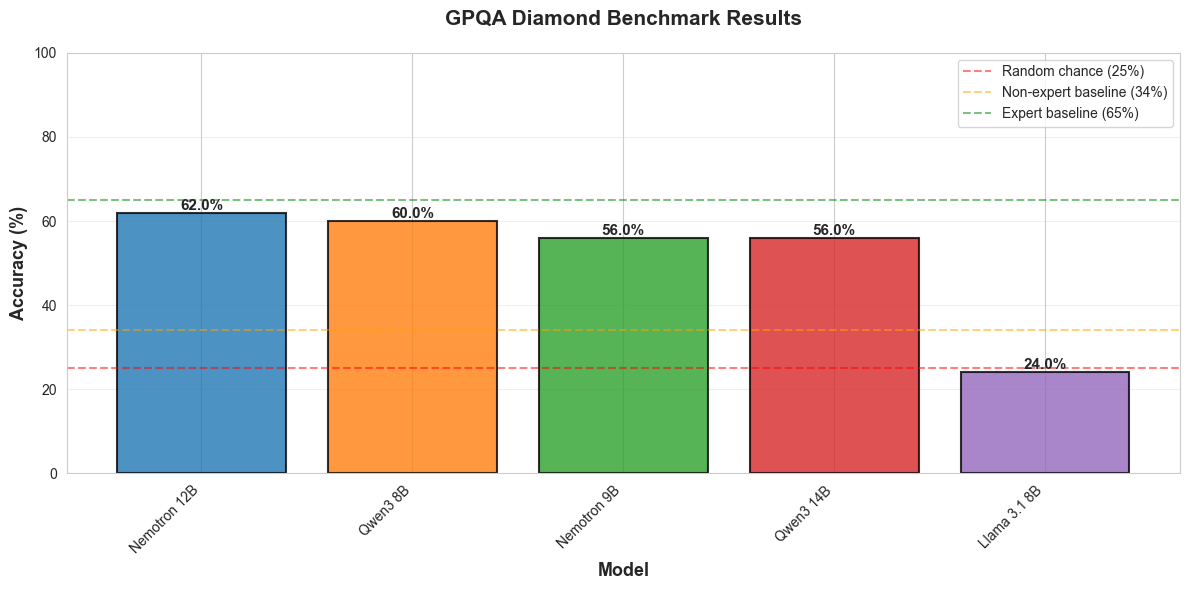


GPQA EVALUATION SUMMARY
Model                Accuracy     Correct      Total      Parse Fail   Sample Size 
----------------------------------------------------------------------------------------------------
Nemotron 12B         62.00        31           50         0            50          
Qwen3 8B             60.00        30           50         8            50          
Nemotron 9B          56.00        28           50         0            50          
Qwen3 14B            56.00        28           50         2            50          
Llama 3.1 8B         24.00        12           50         1            50          

Reference Baselines (from GPQA paper):
  • Random chance: 25%
  • Non-expert validators (PhD in other fields + 30min + internet): 34%
  • Expert validators (PhD in same field): 65%
  • GPT-4 (at paper publication): 39%

✓ GPQA analysis complete!


In [90]:
# Analyze GPQA Results
# ============================================================================
# Load and visualize GPQA evaluation results from log files
# ============================================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import os

# Set style
sns.set_style("whitegrid")

# Get all GPQA log files
gpqa_log_dir = "benchmark/llm_bench/results/gpqa"
log_files = glob.glob(f"{gpqa_log_dir}/gpqa_*.jsonl")

print(f"Found {len(log_files)} GPQA log file(s) in {gpqa_log_dir}")

if not log_files:
    print("\n❌ No GPQA results found. Please run the GPQA evaluation first.")
else:
    # Extract summaries from each log file
    results_data = []
    
    for log_file in log_files:
        with open(log_file, 'r') as f:
            lines = f.readlines()
            # Last line should be the summary
            if lines:
                try:
                    summary = json.loads(lines[-1])
                    if summary.get('summary'):
                        results_data.append(summary)
                        print(f"  ✓ Loaded: {os.path.basename(log_file)}")
                except json.JSONDecodeError:
                    print(f"  ✗ Failed to parse: {os.path.basename(log_file)}")
    
    if not results_data:
        print("\n❌ No valid summary data found in log files.")
    else:
        # Convert to DataFrame
        df = pd.DataFrame(results_data)
        
        # Model display names mapping
        model_display_names = {
            'nemotron_9b': 'Nemotron 9B',
            'nemotron_12b': 'Nemotron 12B',
            'qwen3_8b': 'Qwen3 8B',
            'qwen3_14b': 'Qwen3 14B',
            'llama_3p1_8b': 'Llama 3.1 8B',
        }
        
        df['display_name'] = df['model_name'].map(model_display_names)
        df['display_name'] = df['display_name'].fillna(df['model_name'])
        
        # Sort by accuracy for better visualization
        df = df.sort_values('accuracy', ascending=False)
        
        # Create bar chart
        fig, ax = plt.subplots(figsize=(12, 6))
        
        bars = ax.bar(df['display_name'], df['accuracy'], 
                      color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'][:len(df)],
                      alpha=0.8, edgecolor='black', linewidth=1.5)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}%',
                   ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        # Add baseline reference lines
        ax.axhline(y=25, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='Random chance (25%)')
        ax.axhline(y=34, color='orange', linestyle='--', linewidth=1.5, alpha=0.5, label='Non-expert baseline (34%)')
        ax.axhline(y=65, color='green', linestyle='--', linewidth=1.5, alpha=0.5, label='Expert baseline (65%)')
        
        ax.set_xlabel('Model', fontsize=13, fontweight='bold')
        ax.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
        ax.set_title('GPQA Diamond Benchmark Results', fontsize=15, fontweight='bold', pad=20)
        ax.set_ylim(0, 100)
        ax.legend(loc='upper right', fontsize=10)
        ax.grid(True, alpha=0.3, axis='y')
        
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        # Print detailed results table
        print("\n" + "="*100)
        print("GPQA EVALUATION SUMMARY")
        print("="*100)
        print(f"{'Model':<20} {'Accuracy':<12} {'Correct':<12} {'Total':<10} {'Parse Fail':<12} {'Sample Size':<12}")
        print("-"*100)
        
        for _, row in df.iterrows():
            print(f"{row['display_name']:<20} {row['accuracy']:<12.2f} "
                  f"{row['correct']:<12} {row['total_questions']:<10} "
                  f"{row.get('parsing_failures', 0):<12} {row.get('sample_size', 'Full'):<12}")
        
        print("="*100)
        print("\nReference Baselines (from GPQA paper):")
        print("  • Random chance: 25%")
        print("  • Non-expert validators (PhD in other fields + 30min + internet): 34%")
        print("  • Expert validators (PhD in same field): 65%")
        print("  • GPT-4 (at paper publication): 39%")
        print("\n✓ GPQA analysis complete!")

## Step 4: Qualitative Examples

Beyond quantitative metrics, let's explore some real-world use cases to understand the qualitative differences between models. We'll test:
1. **Creative writing** - Storytelling and imagination
2. **Technical explanation** - Clarity and accuracy in complex topics
3. **Multi-step reasoning** - Problem-solving capabilities
4. **Code debugging** - Practical programming skills


In [91]:
# Define qualitative test prompts
qualitative_prompts = [
    {
        "name": "Creative Writing",
        "prompt": "Write a short story (3-4 sentences) about a robot learning to appreciate art.",
        "evaluation_criteria": ["creativity", "coherence", "completion"]
    },
    {
        "name": "Technical Explanation",
        "prompt": "Explain how a neural network learns during backpropagation in simple terms that a high school student could understand.",
        "evaluation_criteria": ["accuracy", "clarity", "simplicity"]
    },
    {
        "name": "Multi-step Reasoning",
        "prompt": "I have a 5-liter jug and a 3-liter jug. How can I measure exactly 4 liters of water? Explain step by step.",
        "evaluation_criteria": ["correctness", "step-by-step clarity", "completeness"]
    },
    {
        "name": "Code Debugging",
        "prompt": """Find and fix the bug in this Python code:
```python
def calculate_average(numbers):
    total = 0
    for num in numbers:
        total += num
    return total / len(numbers)

print(calculate_average([]))
```""",
        "evaluation_criteria": ["bug identification", "correct fix", "explanation"]
    }
]

print(f"Loaded {len(qualitative_prompts)} qualitative test scenarios")


Loaded 4 qualitative test scenarios


In [99]:
# Run qualitative tests
# ============================================================================
qualitative_results = {}

for model_key, model_config in model_configs.items():
    print(f"\n{'='*80}")
    print(f"Testing: {model_config['display_name']}")
    print(f"{'='*80}")
    
    model_responses = []
    
    for test in qualitative_prompts:
        try:
            response = client.chat.completions.create(
                model=model_config['full_model_id'],
                messages=[{"role": "user", "content": test["prompt"]}],
                max_tokens=128000,
                temperature=0.7
            )
            
            answer = response.choices[0].message.content
            model_responses.append({
                "test_name": test["name"],
                "prompt": test["prompt"],
                "response": answer,
                "criteria": test["evaluation_criteria"]
            })
            
            print(f"✓ {test['name']}")
            
        except Exception as e:
            print(f"✗ {test['name']}: {e}")
            model_responses.append({
                "test_name": test["name"],
                "prompt": test["prompt"],
                "response": f"ERROR: {str(e)}",
                "criteria": test["evaluation_criteria"]
            })
    
    qualitative_results[model_key] = {
        'display_name': model_config['display_name'],
        'responses': model_responses
    }

print("\n✓ Qualitative testing complete!")


Testing: Nemotron 9B
✓ Creative Writing
✓ Technical Explanation
✓ Multi-step Reasoning
✓ Code Debugging

Testing: Nemotron 12B
✓ Creative Writing
✓ Technical Explanation
✓ Multi-step Reasoning
✓ Code Debugging

Testing: Qwen3 8B
✓ Creative Writing
✓ Technical Explanation
✓ Multi-step Reasoning
✓ Code Debugging

Testing: Qwen3 14B
✓ Creative Writing
✓ Technical Explanation
✓ Multi-step Reasoning
✓ Code Debugging

Testing: Llama 3.1 8B
✓ Creative Writing
✓ Technical Explanation
✓ Multi-step Reasoning
✓ Code Debugging

✓ Qualitative testing complete!


### View Qualitative Comparisons

Compare how each model handles different types of tasks:


In [100]:
# Display qualitative results
from IPython.display import Markdown, display

for i, test in enumerate(qualitative_prompts):
    print(f"\n{'='*80}")
    print(f"Test {i+1}: {test['name']}")
    print(f"{'='*80}")
    print(f"\nPrompt: {test['prompt']}")
    print(f"\nEvaluation Criteria: {', '.join(test['evaluation_criteria'])}")
    print(f"\n{'-'*80}")
    print("RESPONSES:")
    print(f"{'-'*80}\n")
    
    for model_key, data in qualitative_results.items():
        if data['responses']:
            response_data = data['responses'][i]
            print(f"\n🔹 {data['display_name']}")
            print(f"{'-'*40}")
            print(response_data['response'])
            print()



Test 1: Creative Writing

Prompt: Write a short story (3-4 sentences) about a robot learning to appreciate art.

Evaluation Criteria: creativity, coherence, completion

--------------------------------------------------------------------------------
RESPONSES:
--------------------------------------------------------------------------------


🔹 Nemotron 9B
----------------------------------------
Okay, the user wants a short story about a robot learning to appreciate art, in 3-4 sentences. Let me start by setting the scene. Maybe a robot in a gallery? That makes sense. I need to show the robot's initial lack of understanding. Maybe it's programmed to analyze but doesn't grasp emotion.

Next, how does it learn? Perhaps an unexpected event, like a child pointing out something. That adds a human element. The robot could then start to notice details it wasn't programmed to see. The key is to show a transformation from mechanical analysis to emotional appreciation.

I should keep it concise

## Step 5: Conclusions & Summary

Let's summarize our findings from the benchmark results.

In [104]:
# Generate summary statistics
# ============================================================================
print("="*80)
print("BENCHMARK SUMMARY")
print("="*80)

print("\n📊 Models Tested:")
for key, config in model_configs.items():
    print(f"  • {config['display_name']}")

print("\n⚡ Performance Benchmarks:")
print("  • QPS sweep: 1, 2, 4, 6, 8, 10, 12 requests/second")
print("  • Duration: 1 minute per QPS value")
print("  • Test configuration: 512 token prompts, 128 token outputs")
print("  • Hardware: 1x NVIDIA H100 GPU per deployment")
print("  • See performance charts above for latency metrics")

print("\n🎯 Accuracy Evaluation (GPQA Diamond):")
print(f"  • Dataset: GPQA Diamond - graduate-level science questions")
print(f"  • Questions per model: 50 (randomly sampled from 198 total)")
print("  • Domains: Biology, Physics, Chemistry, Quantum Mechanics")
print("  • Prompt format: Chain-of-thought with strict answer parsing")
print("  • See accuracy comparison chart above")

print("\n✨ Qualitative Testing:")
print(f"  • {len(qualitative_prompts)} real-world scenarios tested")
print("  • Focus areas: Creative writing, Technical explanations, Reasoning, Code debugging")
print("  • See detailed responses above")

print("\n" + "="*80)

BENCHMARK SUMMARY

📊 Models Tested:
  • Nemotron 9B
  • Nemotron 12B
  • Qwen3 8B
  • Qwen3 14B
  • Llama 3.1 8B

⚡ Performance Benchmarks:
  • QPS sweep: 1, 2, 4, 6, 8, 10, 12 requests/second
  • Duration: 1 minute per QPS value
  • Test configuration: 512 token prompts, 128 token outputs
  • Hardware: 1x NVIDIA H100 GPU per deployment
  • See performance charts above for latency metrics

🎯 Accuracy Evaluation (GPQA Diamond):
  • Dataset: GPQA Diamond - graduate-level science questions
  • Questions per model: 50 (randomly sampled from 198 total)
  • Domains: Biology, Physics, Chemistry, Quantum Mechanics
  • Prompt format: Chain-of-thought with strict answer parsing
  • See accuracy comparison chart above

✨ Qualitative Testing:
  • 4 real-world scenarios tested
  • Focus areas: Creative writing, Technical explanations, Reasoning, Code debugging
  • See detailed responses above



### Key Takeaways

Based on the benchmarking results:

**Performance Metrics:**
- Review the latency charts to understand which models offer the best response times
- Compare TTFT (Time to First Token) for streaming applications
- Consider throughput (requests/second) for high-load scenarios
- Nemotron models are optimized for efficiency - note the performance/size trade-offs

**Accuracy (GPQA Diamond):**
- Compare model accuracy against human expert baselines (34% non-expert, 65% expert)
- Graduate-level science questions test deep reasoning capabilities
- Look for models that perform well across Biology, Physics, and Chemistry
- Consider the trade-off between model size and accuracy

**Qualitative Assessment:**
- Evaluate creativity and writing style for content generation use cases
- Assess technical explanation quality for educational applications
- Review code generation and debugging capabilities
- Different models may excel in different domains

**Deployment Considerations:**
- All models tested on single H100 GPU for fair comparison
- Fireworks AI provides easy deployment via `firectl` CLI
- On-demand deployments allow flexible scaling based on needs
- Consider cost vs. performance for your specific use case


## Cleanup (Optional)

When you're done with the benchmarks, you can delete the deployments to stop incurring costs:


In [ ]:
# Delete all deployments - uncomment and update with your actual deployment IDs:

# !firectl delete deployment accounts/YOUR_ACCOUNT/deployments/DEPLOYMENT_ID_1
# !firectl delete deployment accounts/YOUR_ACCOUNT/deployments/DEPLOYMENT_ID_2
# !firectl delete deployment accounts/YOUR_ACCOUNT/deployments/DEPLOYMENT_ID_3
# !firectl delete deployment accounts/YOUR_ACCOUNT/deployments/DEPLOYMENT_ID_4
# !firectl delete deployment accounts/YOUR_ACCOUNT/deployments/DEPLOYMENT_ID_5

# Verify all deployments are deleted:
# !firectl list deployments


## Next Steps

**To extend this benchmark:**

1. **Full GPQA evaluation**: Set `SAMPLE_SIZE = None` to evaluate on all 198 questions
2. **Add more models**: Deploy and test additional models from the Fireworks catalog
3. **Domain-specific tests**: Create custom evaluation sets for your specific use case
4. **Test with real data**: Replace synthetic prompts with your actual production queries
5. **Multi-GPU deployments**: Test scaling with multiple GPUs for higher throughput

**Resources:**
- [Fireworks AI Documentation](https://docs.fireworks.ai)
- [Firectl CLI Guide](https://docs.fireworks.ai/tools-sdks/firectl/firectl)
- [NVIDIA Nemotron Models](https://arxiv.org/abs/2504.03624)
- [GPQA Dataset Paper](https://arxiv.org/abs/2311.12022)
- [GPQA on Hugging Face](https://huggingface.co/datasets/Idavidrein/gpqa)

**Questions or Issues?**
- Visit [Fireworks AI Discord](https://discord.gg/fireworks-ai)
- Check [Fireworks AI Support](https://fireworks.ai/support)
